In [4]:
import pandas as pd
import fastf1 as ff1
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")  

from reuse.sessions import F1Session

from matplotlib.colors import LinearSegmentedColormap

from plottable import ColumnDefinition, Table
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image

import urllib
import requests
import os

In [2]:
# Create a directory for cache if it doesn't exist
if not os.path.exists('cache'):
    os.makedirs('cache')

In [3]:
ff1.Cache.enable_cache('cache')

In [4]:
races = [
    {'year': 2023, 'circuit': 1, 'session_type': 'R'},
    {'year': 2023, 'circuit': 2, 'session_type': 'R'},
    {'year': 2023, 'circuit': 3, 'session_type': 'R'},
    {'year': 2023, 'circuit': 4, 'session_type': 'R'},
    {'year': 2023, 'circuit': 5, 'session_type': 'R'},
    {'year': 2023, 'circuit': 6, 'session_type': 'R'},
    {'year': 2023, 'circuit': 7, 'session_type': 'R'},
    {'year': 2023, 'circuit': 8, 'session_type': 'R'}
]


In [5]:
f1_session = F1Session(races)

# Create list for all lap_times and session_results
lap_times = []
session_results = []

for session_data in f1_session:
    if session_data is not None:  # check if there's valid data
        lap_times.append(session_data['lap_times'])

# Concatenate all dataframes into one
lap_data = pd.concat(lap_times, ignore_index=True)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.8]
api            INFO 	Using cached data for driver_info


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.8]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO

In [6]:
df = lap_data[['Driver', 'Team', 'LapTime', 'Compound']].groupby(
    ['Driver', 'Team', 'Compound']
).agg({'LapTime': 'mean'}).reset_index()

In [7]:
# add a column that is the number of laps per compound
df['Laps'] = lap_data[['Driver', 'Team', 'LapTime', 'Compound']].groupby(
    ['Driver', 'Team', 'Compound']
).agg({'LapTime': 'count'}).reset_index()['LapTime']


In [8]:
# Convert the LapTime column to seconds
df['LapTime'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()

In [9]:
# Create three columns for lap times based on the compound
df['Soft'] = df['LapTime'].where(df['Compound'] == 'SOFT')
df['Medium'] = df['LapTime'].where(df['Compound'] == 'MEDIUM')
df['Hard'] = df['LapTime'].where(df['Compound'] == 'HARD')

In [10]:
# Create three columns for the count of laps based on the compound
df['SoftLaps'] = df['Laps'].where(df['Compound'] == 'SOFT')
df['MediumLaps'] = df['Laps'].where(df['Compound'] == 'MEDIUM')
df['HardLaps'] = df['Laps'].where(df['Compound'] == 'HARD')

In [11]:
# Drop the compound column
df = df.drop(columns=['Compound'])

In [12]:
# Combine each row into a single row for each driver
df = df.groupby(['Driver', 'Team']).agg({'Soft': 'sum', 'Medium': 'sum', 'Hard': 'sum', 'SoftLaps': 'last', 'MediumLaps': 'last', 'HardLaps': 'last'}).reset_index()

In [13]:
# Replace each time with the delta from the average for that compound
df['Soft'] = df['Soft'] - df['Soft'].mean()
df['Medium'] = df['Medium'] - df['Medium'].mean()
df['Hard'] = df['Hard'] - df['Hard'].mean()

In [14]:
# if theres a value > 90 in the medium column, replace it with nan
df['Medium'] = df['Medium'].where(df['Medium'] > -90)


In [15]:
# Create a new column that holds the filepath to the teams logo
df['Logo'] = df['Team'].apply(lambda x: f'images/logos/{x}.jpg')

In [16]:
def get_drivers_standings():
    # Pull the drivers standings from the Ergast API
    url = "https://ergast.com/api/f1/current/driverStandings.json"
    response = requests.get(url)
    data = response.json()
    drivers_standings = data['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']

    # Add the driver name and team name to the dictionary
    for driver in drivers_standings:
        driver['Driver'] = driver['Driver']['givenName'] + ' ' + driver['Driver']['familyName']
        driver['Team'] = driver['Constructors'][0]['name']

    # Rename the Red Bull team to Red Bull Racing
    for driver in drivers_standings:
        if driver['Team'] == 'Red Bull':
            driver['Team'] = 'Red Bull Racing'

    # List of driver name abbreviations
    driver_abbreviations = {
        'Lewis Hamilton': 'HAM',
        'Max Verstappen': 'VER',
        'Valtteri Bottas': 'BOT',
        'Sergio Pérez': 'PER',
        'Lando Norris': 'NOR',
        'Charles Leclerc': 'LEC',
        'Carlos Sainz': 'SAI',
        'Fernando Alonso': 'ALO',
        'Lance Stroll': 'STR',
        'George Russell': 'RUS',
        'Nico Hülkenberg': 'HUL',
        'Oscar Piastri': 'PIA',
        'Pierre Gasly': 'GAS',
        'Guanyu Zhou': 'ZHO',
        'Kevin Magnussen': 'MAG',
        'Alexander Albon': 'ALB',
        'Logan Sargeant': 'SAR',
        'Nyck de Vries': 'DEV',
        'Yuki Tsunoda': 'TSU',
        'Esteban Ocon': 'OCO',
    }

    # Convert the list of dictionaries to a dataframe
    drivers_standings = pd.DataFrame(drivers_standings)

    # Add a column for the driver abbreviation
    drivers_standings['Driver Abbreviation'] = drivers_standings['Driver'].map(driver_abbreviations)

    # Drop the Constructors column
    drivers_standings = drivers_standings.drop(columns=['Constructors'])

    # Convert the points column to an integer
    drivers_standings['points'] = drivers_standings['points'].astype(int)

    # Rename Driver to Driver Name
    drivers_standings = drivers_standings.rename(columns={'Driver': 'Driver Name'})

    return drivers_standings

In [17]:
# Get the current drivers standings
drivers_standings = get_drivers_standings()

In [18]:
drivers_standings

,position,positionText,points,wins,Driver Name,Team,Driver Abbreviation
0,1,1,195,6,Max Verstappen,Red Bull Racing,VER
1,2,2,126,2,Sergio Pérez,Red Bull Racing,PER
2,3,3,117,0,Fernando Alonso,Aston Martin,ALO
3,4,4,102,0,Lewis Hamilton,Mercedes,HAM
4,5,5,68,0,Carlos Sainz,Ferrari,SAI
5,6,6,65,0,George Russell,Mercedes,RUS
6,7,7,54,0,Charles Leclerc,Ferrari,LEC
7,8,8,37,0,Lance Stroll,Aston Martin,STR
8,9,9,29,0,Esteban Ocon,Alpine F1 Team,OCO
9,10,10,15,0,Pierre Gasly,Alpine F1 Team,GAS


In [19]:
# Join the points and abbreviations to the df dataframe
df = df.merge(drivers_standings[['Driver Abbreviation', 'Driver Name', 'points']], left_on='Driver', right_on='Driver Abbreviation')

In [20]:
# order the dataframe by points
df = df.sort_values(by=['points'], ascending=False)

In [21]:
# Round each delta to 3 decimal places
df['Hard'] = df['Hard'].round(3)
df['Medium'] = df['Medium'].round(3)
df['Soft'] = df['Soft'].round(3)

# Round the lap count to 0 decimal places
df['HardLaps'] = df['HardLaps'].round(0)

In [22]:
# Replace the index with the logo column
df = df.set_index('Logo')

In [23]:
# order the dataframe by points
df = df.sort_values(by=['points'], ascending=False)


In [24]:
# Put the columns in the order Logo, Driver, Team, Hard, HardLaps
df = df[['Team', 'Driver Name', 'points', 'Hard', 'HardLaps', 'Medium', 'MediumLaps', 'Soft', 'SoftLaps']]

In [25]:
plt.rcParams["font.family"] = ["Helvetica"]
plt.rcParams["savefig.bbox"] = "tight"

In [26]:
# Drop na and replace with 0
df = df.fillna(0)

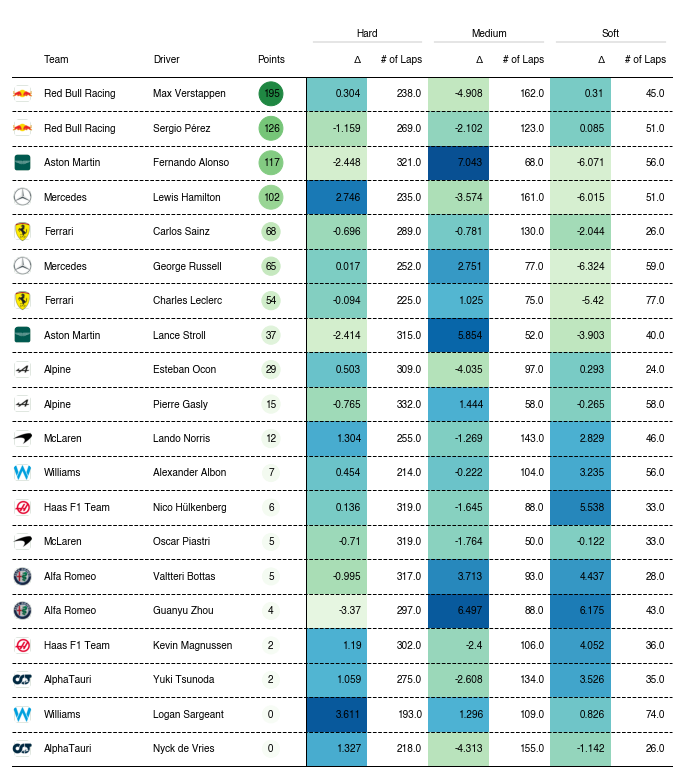

In [27]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from plottable.cmap import normed_cmap

fig, ax = plt.subplots(figsize=(12, 14))

compounds = ['Hard', 'Medium', 'Soft']

# Create plottable tables for the hard compound
hard_table = Table(
    df,
    row_dividers=True,
    footer_divider=True,
    column_definitions=[
        ColumnDefinition('Logo', title='', plot_fn=circled_image, width=0.1),
        ColumnDefinition('Team', title='Team', width=0.55,
                         textprops={"ha": "left", "weight": "bold"}),
        ColumnDefinition('Driver Name', title='Driver', width=0.45, textprops={"ha": "left"}),
        ColumnDefinition('points', title='Points', width=0.35, cmap=plt.cm.Greens, textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.35}
        }),
        ColumnDefinition('Hard', title='Δ', cmap=normed_cmap(df["Hard"], cmap=plt.cm.GnBu, num_stds=2.5),
                         width=0.3, group='Hard', border="left"),
        ColumnDefinition('HardLaps', title='# of Laps',
                         width=0.3, group='Hard'),
        ColumnDefinition('Medium', title='Δ', cmap=normed_cmap(df["Medium"], cmap=plt.cm.GnBu, num_stds=2.5),
                         width=0.3, group='Medium'),
        ColumnDefinition('MediumLaps', title='# of Laps',
                         width=0.3, group='Medium'),
        ColumnDefinition('Soft', title='Δ', cmap=normed_cmap(df["Soft"], cmap=plt.cm.GnBu, num_stds=2.5),
                         width=0.3, group='Soft'),
        ColumnDefinition('SoftLaps', title='# of Laps',
                         width=0.3, group='Soft')
    ],
    row_divider_kw={"linewidth": 1, "linestyle": "dashed"},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "solid"},
)
